In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch.nn.functional as F
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle
import operator
import pdb
import random

from utils import *

In [2]:
CH = 23
time_window = 10
T_length = 9
proceed = 9
device = torch.device('cuda')
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']

In [3]:
val_dates = ['171020','171021','180711','180714']
test_dates = ['171022','171023','180712','180713']
load_path = '/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/'
# save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_yue/model_Goose_Jester/'

In [4]:
def create_files_new(load_path, bad_dates, T_length=10, proceed=1): 
    sleep_files = os.listdir(load_path+'sleep/')
    move_files = os.listdir(load_path+'move/')
    all_files = sleep_files+move_files
    
    dic = {}
    for f in all_files:
        mvmt_type = f.split('_')[-1].split('.')[0]
        date = f.split('_')[0]
        rec = f.split('_')[1].split('_')[0]
        time = float(f.split('_')[3][4:])
        if date in bad_dates:
            continue
        if mvmt_type == 'sleep':
            label = 1
        else:
            label = 0
        if date in dic:
            if rec in dic[date]:
                dic[date][rec].append([f, label, mvmt_type, date, rec, time])
            else:
                dic[date][rec] = [[f, label, mvmt_type, date, rec, time]]
        else:
            dic[date] = {rec: [[f, label, mvmt_type, date, rec, time]]}
        
    for d in dic:
        for r in dic[d]:
            dic[d][r] = sorted(dic[d][r], key=operator.itemgetter(3, 4, 5))
    
    move_data, sleep_data = [], []
    for d in dic:
        for r in dic[d]:
            sleep_grouped, move_grouped = create_files_new_helper(dic[d][r], T_length=T_length, proceed=proceed)
            sleep_data.append(sleep_grouped)
            move_data.append(move_grouped)
    
    return move_data, sleep_data

In [5]:
def create_files_new_helper(L, T_length, proceed):
    L_labels = np.array([L[i][1] for i in range(len(L))])
    L_times = np.array([L[i][-1] for i in range(len(L))])
    
    L_new_sleep, L_new_move = [], []
    start = 0
    while start <= len(L)-T_length:
        end = start + T_length
        #pdb.pm()
        if sum(L_times[start+1:end]-L_times[start:end-1]-time_window) != 0:
            start += 1
            continue
        if sum(L_labels[start:end]) == T_length:
            L_new_sleep.append(L[start:end])
        elif sum(L_labels[start:end]) == 0:
            L_new_move.append(L[start:end])
        start += proceed
    return L_new_sleep, L_new_move

In [6]:
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=T_length, proceed=proceed)
train_files, val_files, test_files = [], [], []
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [7]:
train_files

[[['180411_006_62_time5582.0_move.npy', 0, 'move', '180411', '006', 5582.0],
  ['180411_006_62_time5592.0_move.npy', 0, 'move', '180411', '006', 5592.0],
  ['180411_006_62_time5602.0_move.npy', 0, 'move', '180411', '006', 5602.0],
  ['180411_006_62_time5612.0_move.npy', 0, 'move', '180411', '006', 5612.0],
  ['180411_006_62_time5622.0_move.npy', 0, 'move', '180411', '006', 5622.0],
  ['180411_006_62_time5632.0_move.npy', 0, 'move', '180411', '006', 5632.0],
  ['180411_006_62_time5642.0_move.npy', 0, 'move', '180411', '006', 5642.0],
  ['180411_006_62_time5652.0_move.npy', 0, 'move', '180411', '006', 5652.0],
  ['180411_006_62_time5662.0_move.npy', 0, 'move', '180411', '006', 5662.0]],
 [['180411_006_62_time6544.0_move.npy', 0, 'move', '180411', '006', 6544.0],
  ['180411_006_62_time6554.0_move.npy', 0, 'move', '180411', '006', 6554.0],
  ['180411_006_62_time6564.0_move.npy', 0, 'move', '180411', '006', 6564.0],
  ['180411_006_62_time6574.0_move.npy', 0, 'move', '180411', '006', 6574.0]

In [8]:
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [9]:
def upsample(train_files):
    train_sleep = [i for i in train_files if i[0][1] == 1]
    train_move = [i for i in train_files if i[0][1] == 0]
    diff = abs(len(train_sleep)-len(train_move))
    train_new = []
    d = 0
    while d < diff:
        if len(train_sleep) > len(train_move):
            ind = random.randint(0, len(train_move)-1)
            x = train_move[ind]
            d += 1
        else:
            ind = random.randint(0, len(train_sleep)-1)
            x = train_sleep[ind]
            d += 1
        train_new.append(x)   
    train_files = train_sleep+train_move+train_new
    return train_files

In [10]:
train_files = upsample(train_files)

In [11]:
# val_files = upsample(val_files)

In [83]:
train_files[0]

[['180325_005_62_time2114.0_sleep.npy', 1, 'sleep', '180325', '005', 2114.0],
 ['180325_005_62_time2124.0_sleep.npy', 1, 'sleep', '180325', '005', 2124.0],
 ['180325_005_62_time2134.0_sleep.npy', 1, 'sleep', '180325', '005', 2134.0]]

In [84]:
train_files[1]

[['180324_008_62_time4789.0_sleep.npy', 1, 'sleep', '180324', '008', 4789.0],
 ['180324_008_62_time4799.0_sleep.npy', 1, 'sleep', '180324', '008', 4799.0],
 ['180324_008_62_time4809.0_sleep.npy', 1, 'sleep', '180324', '008', 4809.0]]

In [85]:
train_files[-1]

[['180324_009_62_time690.0_move.npy', 0, 'move', '180324', '009', 690.0],
 ['180324_009_62_time700.0_move.npy', 0, 'move', '180324', '009', 700.0],
 ['180324_009_62_time710.0_move.npy', 0, 'move', '180324', '009', 710.0]]

In [11]:
class SpectrogramDatasetAtt(Dataset):
    def __init__(self, files, load_path, T_length, all_label=False, CH=None):
        self.CH = CH
        self.files = files
        self.load_path = load_path
        self.T_length = T_length
        self.all_label = all_label
  
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        group = self.files[idx]
        specs, labels, dates, recs, times = [], [], [], [], []
        for i in range(len(group)):
            f, label, mvmt_type, date, rec, time = group[i]
            spec = torch.from_numpy(np.load(self.load_path+mvmt_type+'/'+f))
            if self.CH is not None:
                spec = torch.transpose(spec[self.CH,:,:].unsqueeze(0), 2, 1)
            else:
                spec = torch.transpose(spec, 2, 1)
            specs.append(spec)
            labels.append(torch.Tensor([label]))
            dates.append(date)
            recs.append(rec)
            times.append(time)
            if i == (self.T_length-1)/2:
                label_mid = torch.Tensor([label])
                date_mid = date
                rec_mid = rec
                time_mid = time
        if self.all_label:
            return specs, labels, dates, recs, times
        else:
            return specs, label_mid, date_mid, rec_mid, time_mid

In [12]:
train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=T_length, all_label=True, CH=CH)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=T_length, all_label=True, CH=CH)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=T_length, all_label=True, CH=CH)

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=False, CH=CH)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

In [13]:
for a, b, c, d, e in train_loader:
    break

In [14]:
a[1].shape

torch.Size([128, 1, 100, 10])

In [15]:
len(a), len(b)

(9, 9)

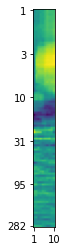

In [16]:
# check if input makes sense
plt.imshow(a[0][0, 0, :, :])
plt.yticks(ticks=[0, 20, 40, 60, 80, 99], labels=[round(np.logspace(0, 2.45, 100)[i]) for i in [0, 20, 40, 60, 80, 99]])
plt.xticks(ticks=[0, 9], labels=[1, 10])
plt.show()

In [16]:
def position_encoding_init(n_position, emb_dim):
    position_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / emb_dim) for j in range(emb_dim)]
        if pos != 0 else np.zeros(emb_dim) for pos in range(n_position)])
    
    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # apply sin on 0th,2nd,4th...emb_dim
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # apply cos on 1st,3rd,5th...emb_dim
    return torch.from_numpy(position_enc).type(torch.FloatTensor)

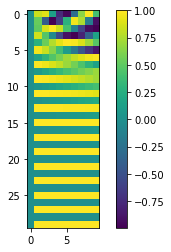

In [17]:
a = position_encoding_init(10, 30).numpy().T
plt.imshow(a)
plt.colorbar()
plt.show()

In [18]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# https://github.com/heykeetae/Self-Attention-GAN/blob/master/sagan_models.py

class CNN(nn.Module):
    def __init__(self, p_dropout, out_dim):
        super(CNN, self).__init__()
        
        # CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(p_dropout)
        self.bn1 = nn.BatchNorm2d(2)
        self.bn2 = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(4*25*2, out_dim)
              
    def forward(self, x):
        # CNN
        x = x.float()
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.shape[0],-1) 
        x = self.dropout(x)
        x = self.fc1(x)
        
        return x
    

class Attention1(nn.Module):
    def __init__(self, att_dim, T_length, all_label=False):
        super(Attention1, self).__init__()
        
        # Positional Encoding
        self.position_enc = nn.Embedding(T_length, att_dim)
        self.position_enc.weight.data = position_encoding_init(T_length, att_dim)

        # Attention
        self.query = nn.Linear(att_dim, att_dim)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=-1) # every slice along dim will sum to 1
        self.ff1 = nn.Linear(att_dim, att_dim)
        self.relu = nn.ReLU()
        self.ff2 = nn.Linear(att_dim, att_dim)
        
        self.fc = nn.Linear(att_dim, 1) # paper uses 2 layers
       
        self.T_length = T_length
        self.all_label = all_label
        
    def forward(self, x, x_pos):
        x = x.float()
        # pdb.pm()
        x += self.position_enc(x_pos)

        Q = self.query(x) 
        energy =  torch.bmm(Q, x.permute(0, 2, 1))
        # attention = self.softmax(self.tanh(energy))
        attention = self.softmax(energy)
        x_att = torch.bmm(attention, x)
       
        x_output = torch.sigmoid(self.fc(x_att))
        # x_fc = self.ff2(self.relu(self.ff1(x_att)))
        # x_output = torch.sigmoid(self.fc(x))
      
        if self.all_label:
            return x_output
        return x_output[:, int((self.T_length-1)/2), :]



In [20]:
def get_accuracy(model_CNN, model_Att, loader, device='cuda'):
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels, _, _, _ in loader:
            labels = torch.stack(labels).transpose(1,0)
            labels = labels.to(device).float()
            CNN_outputs = torch.zeros(data[0].shape[0], len(data), att_dim, device=device)
            for t in range(T_length):
                data_t = data[t].to(device).float()
                CNN_outputs[:, t, :] = model_CNN(data_t)
            pos = torch.LongTensor([list(range(T_length))]).to(device)
            Att_outputs = model_Att(CNN_outputs, pos)
            predictions = (Att_outputs > 0.5) * 1.0
            predictions = predictions.flatten().detach().cpu().numpy()
            labels = labels.flatten().cpu().numpy()
            total += len(labels)
            correct += (predictions == labels).sum()
            
    accuracy = correct / total
    return accuracy

In [22]:
def train(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, loader, T_length, device='cuda'):
    model_CNN.train()
    model_Att.train()
    epoch_losses = 0
    epoch_lens = 0
    
    for batch_idx, (data, labels, _, _, _) in enumerate(loader):
        labels = torch.stack(labels).transpose(1,0)
        labels = labels.to(device).float()
        CNN_outputs = torch.zeros(data[0].shape[0], len(data), att_dim, device=device)
        for t in range(T_length):
            data_t = data[t].to(device).float()
            CNN_outputs[:, t, :] = model_CNN(data_t)
        pos = torch.LongTensor([list(range(T_length))]).to(device)
        Att_outputs = model_Att(CNN_outputs, pos)
        loss = criterion(Att_outputs, labels)
        epoch_losses += loss
        epoch_lens += 1

        optimizer_CNN.zero_grad()
        optimizer_Att.zero_grad()
        loss.backward() # Will back propogation work correctly?
        optimizer_CNN.step()
        optimizer_Att.step()
    
    epoch_accs = get_accuracy(model_CNN, model_Att, loader, device=device)
    return epoch_losses/epoch_lens, epoch_accs

def evaluate(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, loader, T_length, device='cuda'):
    model_CNN.eval()
    model_Att.eval()
    epoch_losses = 0
    epoch_lens = 0
    
    with torch.no_grad():
        for batch_idx, (data, labels, _, _, _) in enumerate(loader):
            labels = torch.stack(labels).transpose(1,0)
            labels = labels.to(device).float()
            CNN_outputs = torch.zeros(data[0].shape[0], len(data), att_dim, device=device)
            for t in range(T_length):
                data_t = data[t].to(device).float()
                CNN_outputs[:, t, :] = model_CNN(data_t)
            pos = torch.LongTensor([list(range(T_length))]).to(device)
            Att_outputs = model_Att(CNN_outputs, pos)
            loss = criterion(Att_outputs, labels)
            epoch_losses += loss
            epoch_lens += 1
    
    epoch_accs = get_accuracy(model_CNN, model_Att, loader, device=device)
    return epoch_losses/epoch_lens, epoch_accs

In [23]:
learning_rate = 0.001
num_epochs = 51
model_type = 'CNN-Attention'
loss_type = 'bce'
p_dropout = 0.2
att_dim = 32
all_label = True
verbose = True

model_CNN = CNN(p_dropout, att_dim).to(device)
model_Att = Attention1(att_dim, T_length, all_label).to(device)
optimizer_CNN = torch.optim.Adam(model_CNN.parameters(), lr = learning_rate)
optimizer_Att = torch.optim.Adam(model_Att.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

0
Train loss for epoch 0: 0.448436439037323
Val loss for epoch 0: 0.4200776219367981
1
Train loss for epoch 1: 0.2807612419128418
Val loss for epoch 1: 0.397784948348999
2
Train loss for epoch 2: 0.23449869453907013
Val loss for epoch 2: 0.3786095082759857
Train loss for epoch 3: 0.20513178408145905
Val loss for epoch 3: 0.41526955366134644
Train loss for epoch 4: 0.19791461527347565
Val loss for epoch 4: 0.4197275638580322
Train loss for epoch 5: 0.17952866852283478
Val loss for epoch 5: 0.4283955991268158
Train loss for epoch 6: 0.17546159029006958
Val loss for epoch 6: 0.44058626890182495
Train loss for epoch 7: 0.16909074783325195
Val loss for epoch 7: 0.44236645102500916
Train loss for epoch 8: 0.16519248485565186
Val loss for epoch 8: 0.46889281272888184
Train loss for epoch 9: 0.15981142222881317
Val loss for epoch 9: 0.43732938170433044
Train loss for epoch 10: 0.1492602527141571
Val loss for epoch 10: 0.4514455795288086
Train loss for epoch 11: 0.1493828445672989
Val loss for 

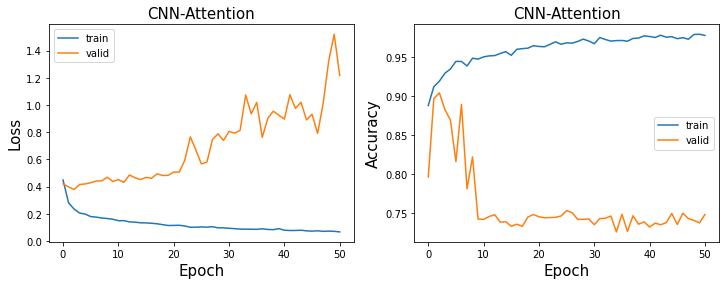

In [24]:
# Attention1 (separate dates, upsample only train, all labels, 32 att dim, T_length=proceed=9)
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, train_loader, T_length=T_length, device='cuda')
    val_loss, val_acc = evaluate(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, val_loader, T_length=T_length, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        # torch.save(model_CNN.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
        # torch.save(model_Att.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
    elif verbose:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
    # if epoch == num_epochs-1:
        # torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
        # torch.save(model_CNN.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [44]:
learning_rate = 0.001
num_epochs = 51
model_type = 'CNN-Attention'
loss_type = 'bce'
p_dropout = 0.2
att_dim = 32
all_label = True
verbose = True

model_CNN = CNN(p_dropout, att_dim).to(device)
model_Att = Attention1(att_dim, T_length, all_label).to(device)
optimizer_CNN = torch.optim.Adam(model_CNN.parameters(), lr = learning_rate)
optimizer_Att = torch.optim.Adam(model_Att.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

0
Train loss for epoch 0: 0.3907758593559265
Val loss for epoch 0: 0.6591483950614929
1
Train loss for epoch 1: 0.3009645342826843
Val loss for epoch 1: 0.568700909614563
2
Train loss for epoch 2: 0.2757264971733093
Val loss for epoch 2: 0.5130866169929504
3
Train loss for epoch 3: 0.26065197587013245
Val loss for epoch 3: 0.49958959221839905
Train loss for epoch 4: 0.25262898206710815
Val loss for epoch 4: 0.5706764459609985
5
Train loss for epoch 5: 0.24248845875263214
Val loss for epoch 5: 0.4376841187477112
Train loss for epoch 6: 0.23361223936080933
Val loss for epoch 6: 0.460005521774292
7
Train loss for epoch 7: 0.22959448397159576
Val loss for epoch 7: 0.4056932032108307
Train loss for epoch 8: 0.22678785026073456
Val loss for epoch 8: 0.4571691155433655
Train loss for epoch 9: 0.2204119712114334
Val loss for epoch 9: 0.4236334264278412
Train loss for epoch 10: 0.2147403508424759
Val loss for epoch 10: 0.5286062359809875
Train loss for epoch 11: 0.21286459267139435
Val loss for

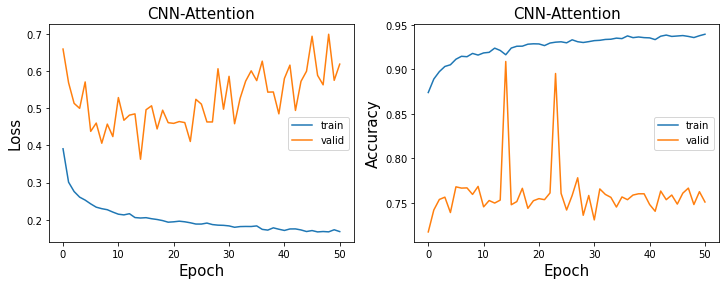

In [45]:
# Attention1 (separate dates, upsample only train, all labels, 32 att dim, T_length=proceed=3)
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, train_loader, T_length=3, device='cuda')
    val_loss, val_acc = evaluate(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, val_loader, T_length=3, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        # torch.save(model_CNN.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
        # torch.save(model_Att.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
    elif verbose:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
    # if epoch == num_epochs-1:
        # torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
        # torch.save(model_CNN.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [21]:
learning_rate = 0.001
num_epochs = 51
model_type = 'CNN-Attention'
loss_type = 'bce'
p_dropout = 0.2
att_dim = 128
T_length = 3
all_label = True # use three labels as opposed to mid one
verbose = True

model_CNN = CNN(p_dropout, att_dim).to(device)
model_Att = Attention1(att_dim, T_length, all_label).to(device)
optimizer_CNN = torch.optim.Adam(model_CNN.parameters(), lr = learning_rate)
optimizer_Att = torch.optim.Adam(model_Att.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

0
Train loss for epoch 0: 0.3780730664730072
Val loss for epoch 0: 0.4574885964393616
Train loss for epoch 1: 0.3071231544017792
Val loss for epoch 1: 0.4975689649581909
2
Train loss for epoch 2: 0.3019830584526062
Val loss for epoch 2: 0.4182394742965698
Train loss for epoch 3: 0.28390610218048096
Val loss for epoch 3: 0.4552482068538666
Train loss for epoch 4: 0.2787597179412842
Val loss for epoch 4: 0.45203644037246704
Train loss for epoch 5: 0.27577337622642517
Val loss for epoch 5: 0.4932301342487335
Train loss for epoch 6: 0.266118586063385
Val loss for epoch 6: 0.45309025049209595
Train loss for epoch 7: 0.26860466599464417
Val loss for epoch 7: 0.4711005985736847
Train loss for epoch 8: 0.2614933252334595
Val loss for epoch 8: 0.475070059299469
Train loss for epoch 9: 0.26326921582221985
Val loss for epoch 9: 0.5140904188156128
Train loss for epoch 10: 0.26194173097610474
Val loss for epoch 10: 0.525111973285675
Train loss for epoch 11: 0.2667064368724823
Val loss for epoch 11:

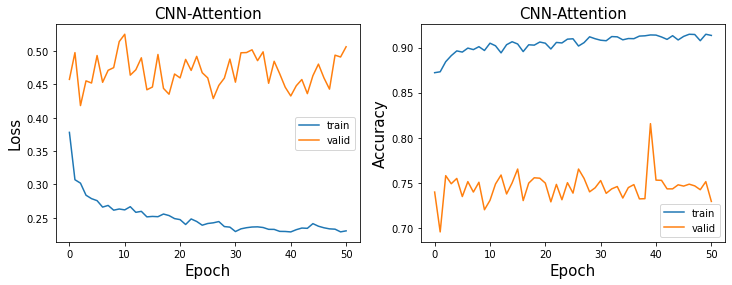

In [22]:
# Attention1 (separate dates, upsample only train, all labels, 128 att dim)
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, train_loader, T_length=3, device='cuda')
    val_loss, val_acc = evaluate(model_CNN, model_Att, optimizer_CNN, optimizer_Att, criterion, val_loader, T_length=3, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        # torch.save(model_CNN.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
        # torch.save(model_Att.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
    elif verbose:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
    # if epoch == num_epochs-1:
        # torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))
        # torch.save(model_CNN.state_dict(), '{}/{}_CH{}_LOSS{}_TW{}_TLEN{}_DROP{}_ATTDIM{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, time_window, T_length, p_dropout, att_dim, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)